# PIK3R1 Effects of Mutation on IRS1

In [8]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

In [9]:
import CPTAC

In [10]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

somatic_mutations.loc[(somatic_mutations['Gene'] == "PIK3R1")]

,Patient_Id,Gene,Mutation,Location,Clinical_Patient_Key
1252,C3L-00090,PIK3R1,Frame_Shift_Ins,p.G588Rfs*14,S005
1382,C3L-00137,PIK3R1,Frame_Shift_Del,p.Q579Vfs*19,S008
1383,C3L-00137,PIK3R1,Frame_Shift_Ins,p.L581Ffs*2,S008
1971,C3L-00145,PIK3R1,In_Frame_Del,p.T576del,S011
3227,C3L-00157,PIK3R1,Frame_Shift_Ins,p.Y467Ifs*2,S013
3458,C3L-00161,PIK3R1,Splice_Site,p.X434_splice,S014
4266,C3L-00361,PIK3R1,Missense_Mutation,p.C656Y,S017
4760,C3L-00563,PIK3R1,Nonstop_Mutation,p.*725Wext*29,S021
8102,C3L-00586,PIK3R1,Nonsense_Mutation,p.R639*,S022
16871,C3L-00601,PIK3R1,Nonsense_Mutation,p.R348*,S023


# PIK3R1 mutation and IRS1 proteome abundance 

#### Take out the control

In [11]:
proteomics = proteomics[:100]

### Perform t-test wiht mutated and non-mutated protein levels

In [12]:
protList = ['IRS1']
pcutoff = 0.05 / len(protList)
gene = 'PIK3R1'

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest)
         
        else:
            print("Unsignificant result for " + protein + ": ")
            print(ttest)

Unsignificant result for IRS1: 
Ttest_indResult(statistic=-1.9457538348130687, pvalue=0.05588092190881759)


## PIK3R1 mutation and IRS1 phosphoproteom abundance

In [16]:
sites = phos.columns
p_values = []
site_names = []


phosProtList = ['IRS1']

alpha = 0.05
p_value = alpha/len(phosProtList)



for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)     
                
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

['IRS1-S1005' 'IRS1-S1100' 'IRS1-S1101' 'IRS1-S1133' 'IRS1-S1134'
 'IRS1-S1222' 'IRS1-S270' 'IRS1-S303' 'IRS1-S312' 'IRS1-S315' 'IRS1-S323'
 'IRS1-S330' 'IRS1-S337' 'IRS1-S348' 'IRS1-S374' 'IRS1-S413' 'IRS1-S415'
 'IRS1-S421' 'IRS1-S463' 'IRS1-S527' 'IRS1-S531' 'IRS1-S629' 'IRS1-S636'
 'IRS1-S672' 'IRS1-S744' 'IRS1-S766' 'IRS1-T305' 'IRS1-T309' 'IRS1-T446'
 'IRS1-T525' 'IRS1-T533' 'IRS1-Y465' 'IRS1-Y662']
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
{'IRS1-S1005': nan, 'IRS1-S1100': nan, 'IRS1-S1101': nan, 'IRS1-S1133': nan, 'IRS1-S1134': nan, 'IRS1-S1222': nan, 'IRS1-S270': nan, 'IRS1-S303': nan, 'IRS1-S312': nan, 'IRS1-S315': nan, 'IRS1-S323': nan, 'IRS1-S330': nan, 'IRS1-S337': nan, 'IRS1-S348': nan, 'IRS1-S374': nan, 'IRS1-S413': nan, 'IRS1-S415': nan, 'IRS1-S421': nan, 'IRS1-S463': nan, 'IRS1-S527': nan, 'IRS1-S531': nan, 'IRS1-S629': nan, 'IRS1-S636': nan, 'IRS1-S672': nan, 'IRS1-S744': nan,

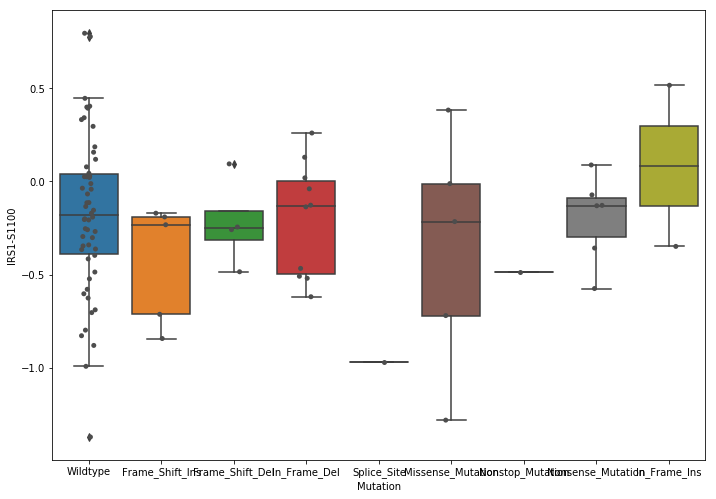

In [14]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)

phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor']

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS1-S1100')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS1-S1100', jitter = True, color = '.3')
plt.show()